# Image Reconstruction with a Neural Network

This notebook demonstrates how to use PyTorch to train a neural network for reconstructing occluded parts of images. The model predicts the mean RGB values of four subregions in the occluded region.

---

## Imports 

In [1]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from find_black_rectangle import find_black_rectangle
import torch.nn as nn
import os
import torch
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Preparing the Dataset

This dataset class loads paired masked and original images, detects the black square (occlusion), splits it into four subregions, and calculates the mean RGB values for each region.

In [2]:
class MaskedImageDataset(Dataset):
    def __init__(self, image_dir, grid_size=8, transform=None):
        # Initialize dataset with directory, grid size, and optional transformations
        self.image_dir = image_dir
        self.image_names = [name for name in os.listdir(image_dir) if not name.endswith("_masked.jpg")]
        self.grid_size = grid_size
        self.transform = transform

    def __len__(self):
        # Return total number of images
        return len(self.image_names)

    def __getitem__(self, idx):
        # Get paths for the original and masked images
        original_name = self.image_names[idx]
        masked_name = original_name.replace(".jpg", "_masked.jpg")
        original_path = os.path.join(self.image_dir, original_name)
        masked_path = os.path.join(self.image_dir, masked_name)

        # Load the images in RGB format
        original_image = Image.open(original_path).convert("RGB")
        masked_image = Image.open(masked_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            original_image = self.transform(original_image)
            masked_image = self.transform(masked_image)

        # Convert images to arrays
        original_array = np.array(original_image.permute(1, 2, 0))
        mask_array = np.array(masked_image.permute(1, 2, 0))

        # Find coordinates of the black rectangle
        y_min, y_max, x_min, x_max = find_black_rectangle(mask_array)

        # Divide the rectangle into a grid
        h_step = (y_max - y_min) // self.grid_size
        w_step = (x_max - x_min) // self.grid_size
        regions = []
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                y1 = y_min + i * h_step
                y2 = y1 + h_step
                x1 = x_min + j * w_step
                x2 = x1 + w_step
                regions.append((y1, y2, x1, x2))

        # Compute mean RGB values for each region
        ground_truth = []
        for y1, y2, x1, x2 in regions:
            region_pixels = original_array[y1:y2, x1:x2, :]
            ground_truth.append(region_pixels.mean(axis=(0, 1)))

        # Convert ground truth to a tensor
        ground_truth = torch.tensor(np.array(ground_truth)).float()

        return masked_image, ground_truth

## Data Transformation and Loader

The images are normalized, and a DataLoader is prepared for efficient data processing.

In [3]:
# Base directory for the dataset
base_dir = os.path.join("..", "Dataset")

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Grid size for splitting the black rectangle
grid_size = 4

# Datasets and Dataloaders
train_dataset = MaskedImageDataset(image_dir=train_dir, transform=transform, grid_size=grid_size)
val_dataset = MaskedImageDataset(image_dir=val_dir, transform=transform, grid_size=grid_size)
test_dataset = MaskedImageDataset(image_dir=test_dir, transform=transform, grid_size=grid_size)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

---
## Color Predictor Neural Network

This block defines a `ColorPredictor` neural network designed to predict the mean RGB values for a grid of regions in an image. The model is composed of convolutional layers for feature extraction and fully connected layers for prediction.

---

### 1. Network Architecture

#### Convolutional Layers:
- **Purpose**: Extract spatial and channel-wise features from the input image.
- **Components**:
  - Convolutional layers with increasing filter sizes (32, 64, 128, and 256 channels) to learn hierarchical features.
  - Batch normalization layers to stabilize training and improve convergence.
  - ReLU activation functions for non-linearity.
  - Max pooling layers for downsampling, reducing the spatial dimensions of the feature maps.

#### Fully Connected Layers:
- **Purpose**: Process the extracted features and predict RGB values for each grid region.
- **Components**:
  - `Flatten`: Converts the feature maps into a single vector.
  - Fully connected layers with 4096 and 2048 neurons for dense feature representation.
  - Batch normalization and dropout layers to improve generalization and reduce overfitting.
  - Final fully connected layer outputs `grid_size^2 * 3` values, representing the RGB values for each grid region.

---

### 2. Parameters and Outputs

- **Input**: A batch of images with shape `(batch_size, 3, height, width)`, where height and width are the spatial dimensions.
- **Output**: A tensor of shape `(batch_size, grid_size^2 * 3)` representing the predicted RGB values for each grid region.

---

### 3. Forward Pass
- The input image is passed through the convolutional layers to extract features.
- The resulting feature maps are flattened and processed by the fully connected layers.
- The final output provides the predicted RGB values for the grid regions.

---

### 4. Key Features
- **Modular Design**: The architecture is divided into convolutional and fully connected layers, allowing flexibility for modifications.
- **Grid-Based Prediction**: The model predicts RGB values for a predefined grid of regions, making it suitable for tasks requiring localized color reconstruction.
- **Scalable**: The grid size (`grid_size`) is parameterized, enabling adaptation to different levels of granularity.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise CPU
print(f"Using device: {device}")

class ColorPredictor(nn.Module):
    def __init__(self, grid_size):
        super(ColorPredictor, self).__init__()
        self.grid_size = grid_size  # Number of regions along one dimension of the grid

        # Convolutional and pooling layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # First conv layer (input: 3 channels, output: 32)
            nn.BatchNorm2d(32),  # Batch normalization for stable training
            nn.ReLU(),  # Activation function
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second conv layer (input: 32 channels, output: 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (224x224 -> 112x112)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third conv layer (input: 64 channels, output: 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Fourth conv layer (input: 128 channels, output: 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (112x112 -> 56x56)

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Fifth conv layer (input: 128 channels, output: 256)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Sixth conv layer (input: 256 channels, output: 256)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling (56x56 -> 28x28)
        )

        # Fully connected layers for grid color prediction
        self.fc = nn.Sequential(
            nn.Flatten(),  # Flatten the feature maps into a single vector
            nn.Linear(256 * 28 * 28, 4096),  # First fully connected layer (input: flattened vector, output: 4096)
            nn.BatchNorm1d(4096),  # Batch normalization for stable training
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(4096, 2048),  # Second fully connected layer (input: 4096, output: 2048)
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, grid_size**2 * 3),  # Final layer (output: grid_size^2 regions × 3 RGB values)
        )

    def forward(self, x):

        x = self.conv(x)  # Extract features using convolutional layers
        x = self.fc(x)  # Predict RGB values using fully connected layers
        return x

Using device: cuda


# Training and Validation of the Color Predictor Model

This block trains the `ColorPredictor` model to predict grid-based RGB values using the Mean Squared Error (MSE) loss. The process includes:

- **Training Phase**: Optimizes model weights using backpropagation and Adam optimizer.
- **Validation Phase**: Evaluates the model on validation data to monitor performance.

Training and validation losses are logged for each epoch and visualized in a plot to track progress over time.


Epoch 1/20 - Train Loss: 0.0919, Val Loss: 0.0455
Epoch 2/20 - Train Loss: 0.0581, Val Loss: 0.0529
Epoch 3/20 - Train Loss: 0.0436, Val Loss: 0.0309
Epoch 4/20 - Train Loss: 0.0374, Val Loss: 0.0314
Epoch 5/20 - Train Loss: 0.0343, Val Loss: 0.0277
Epoch 6/20 - Train Loss: 0.0309, Val Loss: 0.0376
Epoch 7/20 - Train Loss: 0.0274, Val Loss: 0.0259
Epoch 8/20 - Train Loss: 0.0246, Val Loss: 0.0275
Epoch 9/20 - Train Loss: 0.0220, Val Loss: 0.0333
Epoch 10/20 - Train Loss: 0.0203, Val Loss: 0.0290
Epoch 11/20 - Train Loss: 0.0190, Val Loss: 0.0256
Epoch 12/20 - Train Loss: 0.0173, Val Loss: 0.0263
Epoch 13/20 - Train Loss: 0.0163, Val Loss: 0.0292
Epoch 14/20 - Train Loss: 0.0152, Val Loss: 0.0296
Epoch 15/20 - Train Loss: 0.0145, Val Loss: 0.0416
Epoch 16/20 - Train Loss: 0.0135, Val Loss: 0.0360
Epoch 17/20 - Train Loss: 0.0128, Val Loss: 0.0415
Epoch 18/20 - Train Loss: 0.0122, Val Loss: 0.0417
Epoch 19/20 - Train Loss: 0.0115, Val Loss: 0.0365
Epoch 20/20 - Train Loss: 0.0110, Val Lo

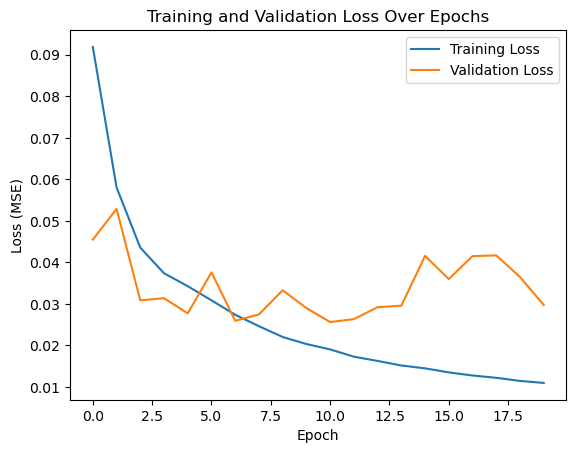

In [5]:
# Define the model, criterion, and optimizer
model = ColorPredictor(grid_size=grid_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20
train_losses = []
val_losses = []  # For storing validation losses

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for masked_images, ground_truths in train_dataloader:
        optimizer.zero_grad()
        
        # Move data to GPU
        masked_images = masked_images.to(device)
        ground_truths = ground_truths.to(device)
        
        # Forward pass
        outputs = model(masked_images)  # Shape: [batch_size, grid_size**2 * 3]
    
        # Compute loss
        loss = criterion(outputs, ground_truths.view(-1, grid_size**2 * 3))  # Reshape ground_truths to match outputs
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dataloader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_ground_truths in val_dataloader:
            
            # Move validation data to GPU
            val_images = val_images.to(device)
            val_ground_truths = val_ground_truths.to(device)
            
            val_outputs = model(val_images)  # Forward pass
            
            # Compute validation loss
            loss = criterion(val_outputs, val_ground_truths.view(-1, grid_size**2 * 3))  # Reshape ground_truths
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    # Print losses for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plot training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

---
## Overlay Predicted Colors

This function replaces the black rectangle in a masked image with predicted RGB values, divided into a grid based on `grid_size`.


In [6]:
# Function to overlay predictions on the black rectangle of the original masked image
def overlay_predictions_on_black_rectangle(masked_image, predictions, grid_size):
    """Overlay the predicted RGB regions on the black rectangle of the original masked image."""
    # Normalize masked_image to [0, 1] for find_black_rectangle
    masked_image_normalized = masked_image / 255.0 if masked_image.max() > 1 else masked_image
    black_box_coords = find_black_rectangle(masked_image_normalized)
    y_min, y_max, x_min, x_max = black_box_coords

    # Calculate the height and width of each region
    region_height = (y_max - y_min) // grid_size
    region_width = (x_max - x_min) // grid_size

    # Convert tensor to numpy if needed
    if isinstance(masked_image, torch.Tensor):
        masked_image = masked_image.permute(1, 2, 0).cpu().numpy()

    # Overlay the predicted RGB colors in the corresponding regions
    for i in range(grid_size):
        for j in range(grid_size):
            y1 = y_min + i * region_height
            y2 = y1 + region_height
            x1 = x_min + j * region_width
            x2 = x1 + region_width
            region_idx = i * grid_size + j  # Calculate the region index
            predicted_color = (predictions[region_idx] * 255.0).astype(np.uint8)  # Scale predictions to [0, 255]
            masked_image[y1:y2, x1:x2, :] = predicted_color  # Overlay predicted RGB values

    return masked_image

## Testing the Model

The test dataset is used to evaluate the final model and compute MSE and MAE metrics.

In [7]:
# Define the dataset directory relative to the script
dataset_dir = os.path.join("..", "Dataset", "test")

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Metrics for mean color vs. output color
test_mse, test_mae = 0.0, 0.0
mse_list = []
mae_list = []

# Evaluation loop
with torch.no_grad():
    for idx, (masked_images, ground_truths) in enumerate(test_dataloader):
        # Move data to the correct device
        masked_images = masked_images.to(device)
        ground_truths = ground_truths.to(device)

        # Flatten ground_truths to match the model's output
        batch_size = masked_images.size(0)
        ground_truths = ground_truths.view(batch_size, -1)

        # Forward pass
        outputs = model(masked_images)

        # Convert tensors to NumPy arrays
        ground_truths_np = ground_truths.cpu().numpy()
        outputs_np = outputs.cpu().numpy()

        # Ensure shapes match
        assert ground_truths_np.shape == outputs_np.shape, \
            f"Shape mismatch: {ground_truths_np.shape} vs {outputs_np.shape}"

        # Calculate grid-based metrics
        batch_mse = mean_squared_error(ground_truths_np, outputs_np)
        batch_mae = mean_absolute_error(ground_truths_np, outputs_np)
        test_mse += batch_mse
        test_mae += batch_mae


        for i in range(batch_size):
            # Masked image for overlay
            masked_image = (masked_images[i] * 255.0).permute(1, 2, 0).cpu().numpy().astype(np.float32)

            # Get the corresponding original image path
            masked_image_path = test_dataloader.dataset.image_names[idx * batch_size + i]
            original_image_name = masked_image_path.replace("_masked", "")
            original_image_full_path = os.path.join(dataset_dir, original_image_name)

            # Load original image
            original_image = Image.open(original_image_full_path).convert("RGB")
            original_image = np.array(original_image).astype(np.float32)

            # Overlay predictions onto the masked image
            predictions = outputs_np[i].reshape(-1, 3)  # Reshape predictions to match grid format
            overlay_image = overlay_predictions_on_black_rectangle(masked_image.copy(), predictions, grid_size)

            # Ensure shapes match for comparison
            assert original_image.shape == overlay_image.shape, \
                f"Shape mismatch: {original_image.shape} vs {overlay_image.shape}"

            # Compute pixel-level metrics
            mse_list.append(mean_squared_error(original_image.flatten(), overlay_image.flatten()))
            mae_list.append(mean_absolute_error(original_image.flatten(), overlay_image.flatten()))
     

# Pixel-level evaluation
average_pixel_mse = np.mean(mse_list)
average_pixel_mae = np.mean(mae_list)

# Average the grid-based metrics
test_mse /= len(test_dataloader)
test_mae /= len(test_dataloader)

# Print combined results
print("\nGrid-Based Metrics (Mean Color vs. Output Color):")
print(f"  Test Grid MSE: {test_mse:.4f}")
print(f"  Test Grid MAE: {test_mae:.4f}")

print("\nPixel-Based Metrics (Original vs. Overlay Images):")
print(f"  Pixel MSE: {average_pixel_mse:.2f}")
print(f"  Pixel MAE: {average_pixel_mae:.2f}")


Grid-Based Metrics (Mean Color vs. Output Color):
  Test Grid MSE: 0.0265
  Test Grid MAE: 0.1194

Pixel-Based Metrics (Original vs. Overlay Images):
  Pixel MSE: 399.70
  Pixel MAE: 3.65


## Final Visualization with Refrence_Images

We generate reconstructed images and display them alongside the masked images.

Using device: cuda


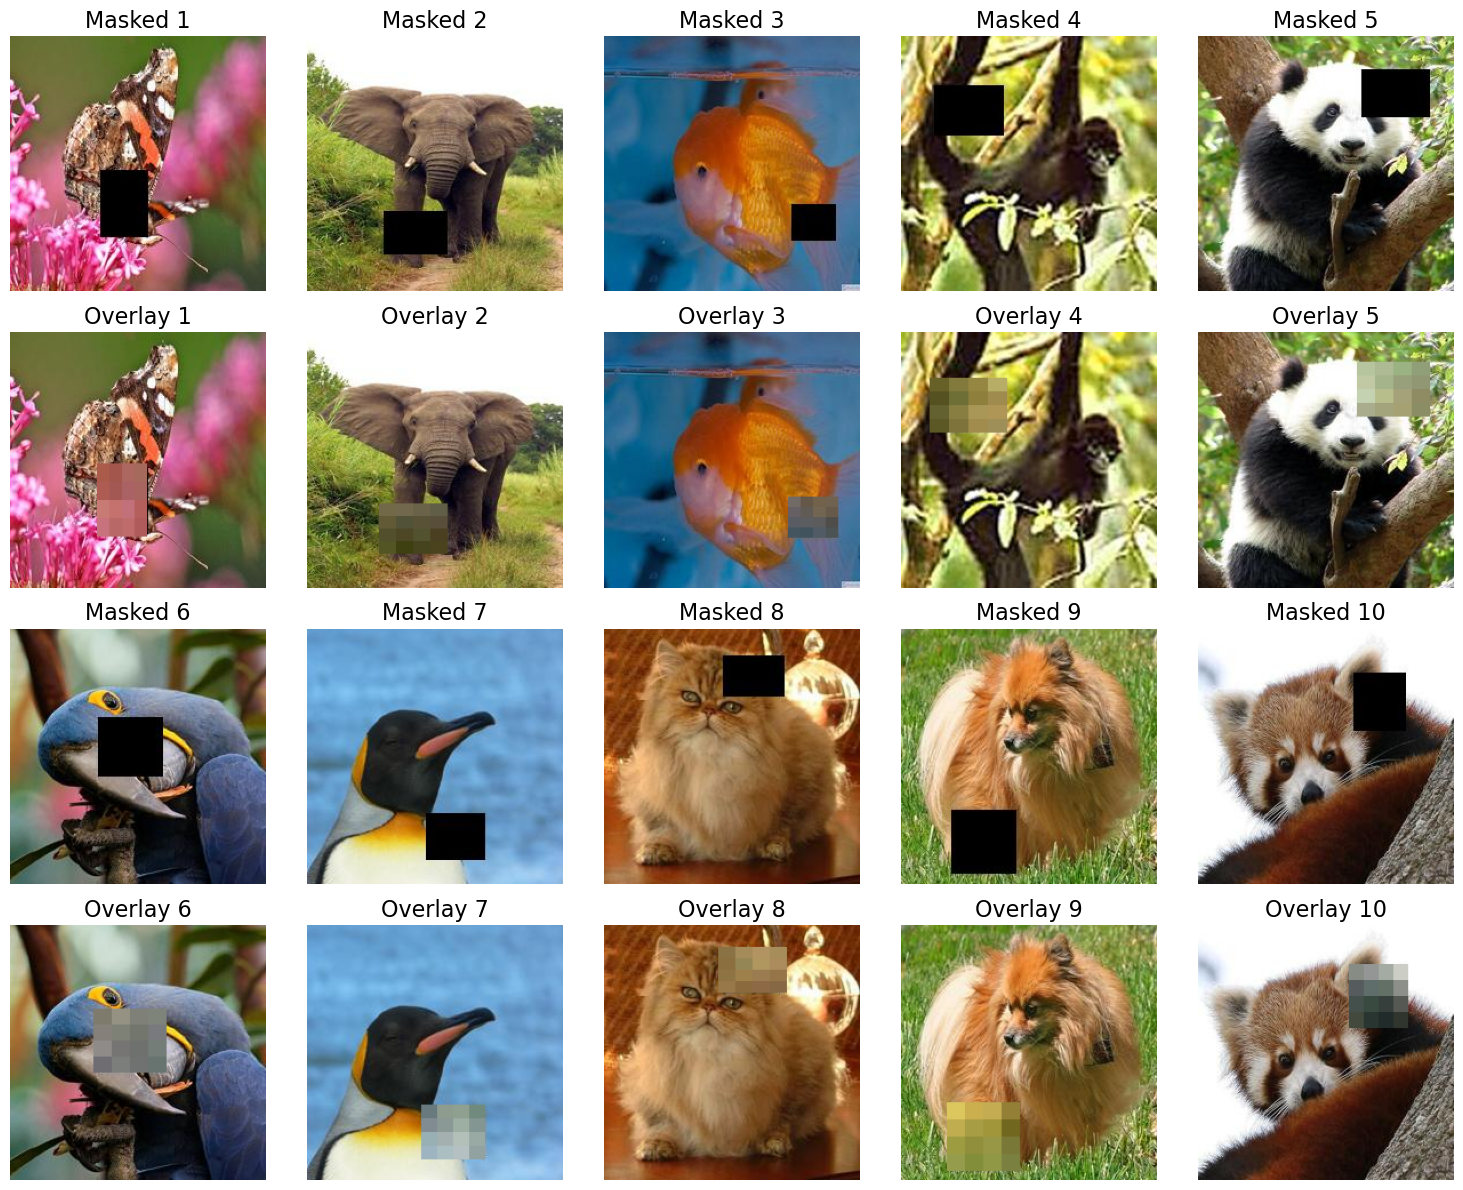

In [11]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Path to the Reference_Images directory
reference_images_dir = os.path.join("..", "Reference_Images")
masked_image_files = sorted(os.listdir(reference_images_dir))

# Load and process masked images from the directory
masked_images = []
for file_name in masked_image_files:
    image_path = os.path.join(reference_images_dir, file_name)
    masked_image = Image.open(image_path).convert("RGB")  # Open image in RGB format
    masked_images.append(transform(masked_image))  # Apply transformations (e.g., ToTensor)

# Stack into a batch and move to the device
masked_images = torch.stack(masked_images).to(device)  # Shape: [batch_size, channels, height, width]

# Ensure the model is on the correct device
model.to(device)
model.eval()

# Generate reconstructed images using the trained model
with torch.no_grad():
    generated_images = model(masked_images)  # Model output
    generated_images = generated_images.cpu()  # Move to CPU for further processing

# Reshape generated_images to [batch_size, grid_size**2, 3]
generated_images = generated_images.view(-1, grid_size**2, 3)  # Dynamic shape based on grid_size

# Visualization with a 4-row grid
fig, axs = plt.subplots(4, 5, figsize=(15, 12))  # 4 rows, 5 columns for 10 images

# Convert tensors to [height, width, channels] for imshow
masked_images_np = (masked_images * 255.0).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)

# First set of images (rows 1 and 2)
for i in range(5):
    # Row 1: Masked images
    axs[0, i].imshow(masked_images_np[i])
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Masked {i+1}", fontsize=16)

    # Row 2: Reconstructed images with overlays
    overlay_image = overlay_predictions_on_black_rectangle(
        masked_images_np[i].copy(), np.clip(generated_images[i].numpy(), 0, 1), grid_size
    )
    axs[1, i].imshow(overlay_image)
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Prediction {i+1}", fontsize=16)

# Second set of images (rows 3 and 4)
for i in range(5, 10):
    # Row 3: Masked images
    axs[2, i - 5].imshow(masked_images_np[i])
    axs[2, i - 5].axis("off")
    axs[2, i - 5].set_title(f"Masked {i+1}", fontsize=16)

    # Row 4: Reconstructed images with overlays
    overlay_image = overlay_predictions_on_black_rectangle(
        masked_images_np[i].copy(), np.clip(generated_images[i].numpy(), 0, 1), grid_size
    )
    axs[3, i - 5].imshow(overlay_image)
    axs[3, i - 5].axis("off")
    axs[3, i - 5].set_title(f"Prediction {i+1}", fontsize=16)

plt.tight_layout()
plt.show()


# Saving the Trained Model

After training, we need to save the model's parameters so that it can be reused for inference or further training. 
The following code saves the model's state dictionary to a file.

In [9]:
# Define the save path
model_save_path = os.path.join("..", "saved_models", "Neural_network", "NeuralNetwork_ImageReconstruction_testing.pth")

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save only the model's state dictionary
try:
    torch.save(model.state_dict(), model_save_path)  # Save only the weights
    print(f"Model successfully saved to {model_save_path}")
except Exception as e:
    print(f"Error saving the model: {e}")

Model successfully saved to ..\saved_models\Neural_network\NeuralNetwork_ImageReconstruction_testing.pth
